In [1]:
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import importlib
import numpy as np
from configobj import ConfigObj
from findiff import FinDiff
from scipy.integrate import simps
from scipy.interpolate import splrep, splev
from scipy.linalg.lapack import dgesv
from scipy.integrate import quad
from itertools import combinations_with_replacement
from TackleBox import compute_deriv_alphas, get_powerfx, get_full_deriv, compute_inv_cov, get_inv_cov, CastNet, compute_recon, get_dfactor, Fish
from ioutils import CosmoResults, InputData, write_fisher
import matplotlib.pyplot as plt

#gathering data and set up
configpath = os.path.join(parent, "test.ini")
pardict = ConfigObj(configpath)

# resolve inputfile relative to the ini file location
ini_dir = os.path.dirname(configpath)
inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
pardict["inputfile"] = os.path.abspath(inputfile_path)
pardict = ConfigObj(configpath)
data = InputData(pardict)
cosmo = CosmoResults(pardict, data.zmin, data.zmax) # edit for new Pv values
if np.any(data.volume > 0):
    cosmo.volume = data.volume * 1.0e9
data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))
muvec = np.linspace(0.0, 1.0, 100)
kvec = np.linspace(cosmo.kmin, cosmo.kmax, 400)
pkval = splev(kvec, cosmo.pk[0])
pksmoothval = splev(kvec, cosmo.pksmooth[0])
npop = np.shape(data.nbar)[0]
npk = int(npop*(npop+1)/2)
derPalpha = compute_deriv_alphas(cosmo,BAO_only=False)
coords = [[kval, muval] for kval in kvec for muval in muvec]
derPalphaval = np.array([
derPalpha[i](coords).reshape(len(kvec), len(muvec)) * (cosmo.sigma8[0] / cosmo.sigma8[0]) ** 2
for i in range(2)
]) # 2x400x100 array containing perp and para derivative wrt alpha for each k and mu value
kaiser = (np.tile(data.bias[:, 0], (len(muvec), 1)).T + cosmo.f[0] * muvec ** 2)
fval,sigmaval,zval,hval,nbarval,vbarval,pverr,vol,dk,dmu=cosmo.f[0],cosmo.sigma8[0],cosmo.z[0],cosmo.h[0],data.nbar[0,0],data.nbar[1,0],data.pverr[0,0],cosmo.volume[0],kvec[1]-kvec[0],muvec[1]-muvec[0]

/root/enidh/code/capstone/Capstone-Project/ioutils.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


FileNotFoundError: [Errno 2] No such file or directory: './data.txt'

In [3]:
print(vol)

NameError: name 'vol' is not defined

In [2]:
print(vol,dk)

35605260.67116556 0.0002481203007518797


In [3]:
pgg=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of pgg at each k and mu value
pgu=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of pgu at each k and mu value
puu=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of puu at each k and mu value

bder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt b at each k and mu value
fder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt f at each k and mu value
aperder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt aperp at each k and mu value
aparder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt apara at each k and mu value

cov=np.zeros((3,3,len(kvec),len(muvec))) # covariance info, 3x3 for Pgg Pgu Puu and then k and mu
invcov=np.zeros((3,3,len(kvec),len(muvec))) # inverse covariance info
fisherinfo=np.zeros((4,4,len(kvec),len(muvec))) # fisher info, 4x4 for the 4 derivatives and then k and mu

In [4]:
# populate these arrays
sigpar,sigperp=cosmo.Sigma_par[0],cosmo.Sigma_perp[0]
recon=compute_recon(cosmo,data)
for i, kval in enumerate(kvec):
    for j, muval in enumerate(muvec):
        dfactor=get_dfactor(muval,kval,recon,sigpar,sigperp)
        dfactorarr=np.ones((4,4))*dfactor
        pgg[i,j],pgu[i,j],puu[i,j]=get_powerfx(kval,muval,pkval[i],kaiser[j],fval,zval,hval)
        info=get_full_deriv(kval,muval,pkval[i],kaiser[j],fval,zval,hval,derPalphaval[:,i,j],sigmaval) # then multiply by Dfactor**2 -> same for 4, different for power spec, make them the same for now.
        bder[:,i,j],fder[:,i,j],aperder[:,i,j],aparder[:,i,j]=info[:,0],info[:,1],info[:,2],info[:,3]
        cov[:,:,i,j],invcov[:,:,i,j]=get_inv_cov(pgg[i,j],pgu[i,j],puu[i,j],nbarval,vbarval,pverr,kval,vol,dk) # this is inversed!! k**2 * cosmo.volume[iz] delta k / (2.0 * np.pi ** 2) -> add to this!! and k**2
        fisherinfo[:,:,i,j] = info.T @ invcov[:,:,i,j] @ info * dfactorarr ** 2# integrate over mu and k -> use old functions
        #cov[:,:,i,j],invcov[:,:,i,j]=get_cov_and_inv(pgg[i,j], pgu[i,j], puu[i,j], nbarval, vbarval, pverr, cosmo.kmin, cosmo.kmax, vol,dmu)

ValueError: setting an array element with a sequence.

In [ ]:
muvec = np.linspace(0.0, 1.0, 100)
kvec = np.linspace(cosmo.kmin, cosmo.kmax, 400)
test = simps(simps(fisherinfo, x=muvec, axis=-1),x=kvec,axis=-1,)

/tmp/ipykernel_80009/1628681875.py:3: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  test = simps(simps(fisherinfo, x=muvec, axis=-1),x=kvec,axis=-1,)


In [ ]:
finalcov=np.linalg.inv(test)

fs8_mean = fval*sigmaval
Da_mean  = cosmo.da[0]
H_mean   = hval

print(fs8_mean)

means = np.array([fs8_mean, Da_mean, H_mean])
jacobian = np.identity(finalcov.shape[0])
jacobian[-2, -2] = means[1]
jacobian[-1, -1] = -means[2]
cov_renorm = jacobian @ finalcov @ jacobian.T

errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
print(means, errs)

0.44077646256128955
[  0.44077646 209.40487718  69.01358329] [197.08884546   0.51185047   0.53282359]


In [1]:
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import importlib
import numpy as np
from configobj import ConfigObj
from findiff import FinDiff
from scipy.integrate import simps
from scipy.interpolate import splrep, splev
from scipy.linalg.lapack import dgesv
from scipy.integrate import quad
from itertools import combinations_with_replacement
from TackleBox import compute_deriv_alphas, get_powerfx, get_full_deriv, compute_inv_cov, get_inv_cov, CastNet, get_cov_and_inv, compute_recon, get_dfactor, Fish
from ioutils import CosmoResults, InputData, write_fisher
import matplotlib.pyplot as plt

#gathering data and set up
pardict = ConfigObj(configpath)
data = InputData(pardict)
cosmo = CosmoResults(pardict, data.zmin, data.zmax) # edit for new Pv values
if np.any(data.volume > 0):
    cosmo.volume = data.volume * 1.0e9
data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))
muvec = np.linspace(0.0, 1.0, 100)
kvec = np.linspace(cosmo.kmin, cosmo.kmax, 400)
pkval = splev(kvec, cosmo.pk[0])
pksmoothval = splev(kvec, cosmo.pksmooth[0])
npop = np.shape(data.nbar)[0]
npk = int(npop*(npop+1)/2)
derPalpha = compute_deriv_alphas(cosmo,BAO_only=False)
coords = [[kval, muval] for kval in kvec for muval in muvec]
derPalphaval = np.array([
derPalpha[i](coords).reshape(len(kvec), len(muvec)) * (cosmo.sigma8[0] / cosmo.sigma8[0]) ** 2
for i in range(2)
]) # 2x400x100 array containing perp and para derivative wrt alpha for each k and mu value
kaiser = (np.tile(data.bias[:, 0], (len(muvec), 1)).T + cosmo.f[0] * muvec ** 2)
recon=compute_recon(cosmo,data)
fval,sigmaval,zval,hval,nbarval,vbarval,pverr,vol,dk,dmu=cosmo.f[0],cosmo.sigma8[0],cosmo.z[0],cosmo.h[0],data.nbar[0,0],data.nbar[1,0],data.pverr[0,0],cosmo.volume[0],kvec[1]-kvec[0],muvec[1]-muvec[0]

/root/enidh/code/capstone/Capstone-Project/ioutils.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [2]:
slay=Fish(cosmo, cosmo.kmin, cosmo.kmax, data, 0, recon, derPalpha, BAO_only=False, GoFast=True)

(1, 100)
2 3


ValueError: could not broadcast input array from shape (0,) into shape (1,)

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_61340/3593044811.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.title('P$_{{gg}}$ with errorbars at $\mu$={:.2f}'.format(muvec[i]))


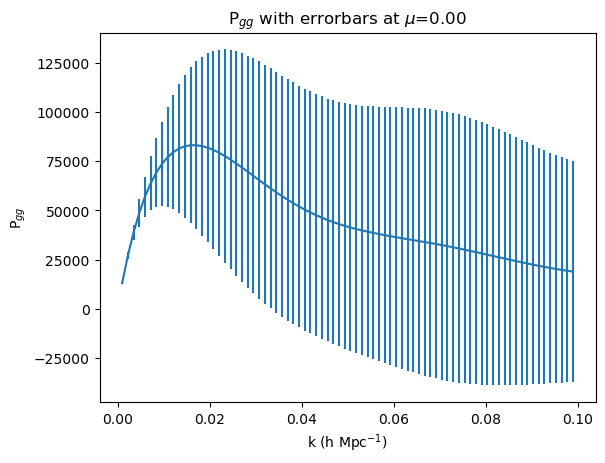

In [7]:
for i in range(1):
    plt.errorbar(kvec[::5],(pgg[:,99])[::5],yerr=(np.sqrt(cov[0,0,:,99]))[::5])
    plt.xlabel('k (h Mpc$^{-1}$)')
    plt.ylabel('P$_{gg}$')
    plt.title('P$_{{gg}}$ with errorbars at $\mu$={:.2f}'.format(muvec[i]))
    plt.show() #something is up, kvals make it baaaad
    #path = '../../Data/Storage2/{:03d}.png'.format(i)
    #plt.savefig(path, dpi=300)
    #plt.close()

In [8]:
CastNet(muvec, kvec, 0, npop, npk, data, cosmo, recon, derPalpha, BAO_only) #problemsss

NameError: name 'BAO_only' is not defined

In [45]:
from PIL import Image, ImageDraw
folder_path = "../../Data/Storage2"
output_folder = "../Figures"
output_gif = os.path.join(output_folder, "Pgg Errorbars.gif")
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()
images = [Image.open(img) for img in image_files]
images[0].save(output_gif, save_all=True, append_images=images[1:], duration=100, loop=0)

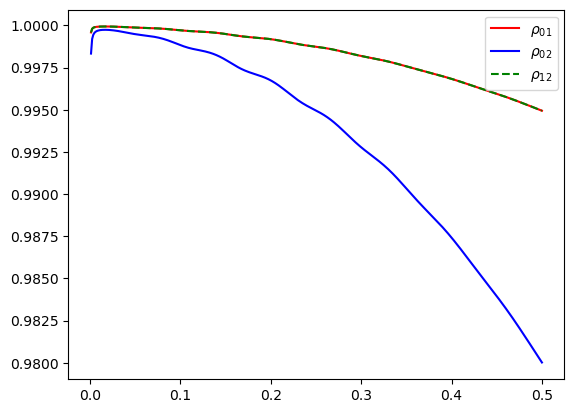

In [4]:
# plot correlation coeff Cij/sqrt(Cii*Cjj) (for all combos 0 1 2) i=0, j=1, i=1, j=2, i=0, j=2 #0,1 represents Pgg Pgu, 0,2 represents Pgg Puu, 1,2 represents Pgu Puu
icombo=[0,0,1]
jcombo=[1,2,2]
coloring=['r','b','g']
idx=99
for i in range(3):
    correlcoef=cov[icombo[i],jcombo[i],:,idx]/(np.sqrt(cov[icombo[i],icombo[i],:,idx]*cov[jcombo[i],jcombo[i],:,idx]))
    if i==2:
        plt.plot(kvec,correlcoef,label='$\\rho_{{{:.0f}{:.0f}}}$'.format(icombo[i],jcombo[i]),linestyle='--',color=coloring[i])
    else:
        plt.plot(kvec,correlcoef,label='$\\rho_{{{:.0f}{:.0f}}}$'.format(icombo[i],jcombo[i]),color=coloring[i])
plt.legend()
plt.show()

In [12]:
print(cov[0,1,3,99],np.sqrt(cov[0,0,3,99]*cov[1,1,3,99]),cov[0,1,3,99]/np.sqrt(cov[0,0,3,99]*cov[1,1,3,99]))
print(cov[1,2,3,99],np.sqrt(cov[1,1,3,99]*cov[2,2,3,99]),cov[1,2,3,99]/np.sqrt(cov[1,1,3,99]*cov[2,2,3,99]))

19493692415264.67 19495865870321.594 0.9998885171312021
3.222281824769103e+20 3.222641094043373e+20 0.9998885171312022


<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_114389/793520797.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(kvec,correlcoef,label='$\mu={:.0f}$'.format(cmu[i]),color=coloring[i])


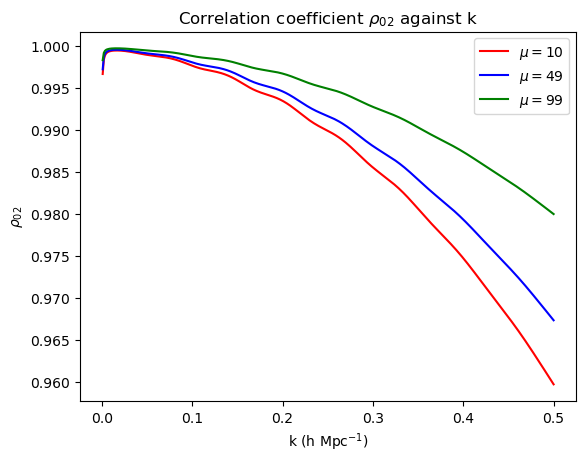

In [9]:
# plot correlation coeff Cij/sqrt(Cii*Cjj) (for all combos 0 1 2) i=0, j=1, i=1, j=2, i=0, j=2 #0,1 represents Pgg Pgu, 0,2 represents Pgg Puu, 1,2 represents Pgu Puu
cmu=[10,49,99]
#icombo=[0,0,1]
#jcombo=[1,2,2]
coloring=['r','b','g']
for i in range(3):
    correlcoef=cov[0,2,:,cmu[i]]/(np.sqrt(cov[0,0,:,cmu[i]]*cov[2,2,:,cmu[i]]))
    plt.plot(kvec,correlcoef,label='$\mu={:.0f}$'.format(cmu[i]),color=coloring[i])
plt.legend()
plt.title('Correlation coefficient $\\rho_{02}$ against k')
plt.ylabel('$\\rho_{02}$')
plt.xlabel('k (h Mpc$^{-1}$)')
plt.show()
#path = '../Figures/Correlation 02.png'
#plt.savefig(path, dpi=300)
#plt.close()

In [142]:
cmu=[10,49,99]
#icombo=[0,0,1]
#jcombo=[1,2,2]
coloring=['r','b','g']
q,r=1,2
for i in range(3):
    plt.plot(kvec,cov[q,r,:,cmu[i]]*kvec**3,label='$\mu={:.0f}$'.format(cmu[i]),color=coloring[i])
plt.legend()
plt.title('C$_{{{:.0f}{:.0f}}}$ against k'.format(q,r))
plt.ylabel('C$_{{{:.0f}{:.0f}}}k^3$'.format(q,r))
plt.xlabel('k (h Mpc$^{-1}$)')
path = '../Figures/Covariance {:.0f}{:.0f}.png'.format(q,r)
plt.savefig(path, dpi=300)
plt.close()

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_15904/1977396551.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(kvec,cov[q,r,:,cmu[i]]*kvec**3,label='$\mu={:.0f}$'.format(cmu[i]),color=coloring[i])


In [82]:
for i in range(len(muvec)):
    plt.plot(kvec,1/(pgg[:,i])*bder[0,:,i],color='r',label='b$\sigma_8$')
    plt.plot(kvec,1/(pgg[:,i])*fder[0,:,i],color='b',label='f$\sigma_8$')
    plt.plot(kvec,1/(pgg[:,i])*aperder[0,:,i],color='g',label='$\\alpha_{\perp}$')
    plt.plot(kvec,1/(pgg[:,i])*aparder[0,:,i],color='m',label='$\\alpha_{\parallel}$')
    plt.xlabel('k (h MPC$^{-1}$)')
    plt.ylabel('$\\frac{1}{P_{gg}}$ $\\frac{dP_{gg}}{d\\theta_i}$',fontsize=15,labelpad=-5)
    plt.title('Derivatives of $P_{gg}$')
    plt.xlim(-0.01,0.51)
    plt.ylim(-2,5)
    plt.legend(loc=1)
    path = '../../Data/Pgg/{:03d}'.format(i)
    plt.savefig(path, dpi=300)
    plt.close()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_65982/84847993.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(kvec,1/(pgg[:,i])*bder[0,:,i],color='r',label='b$\sigma_8$')
/tmp/ipykernel_65982/84847993.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(kvec,1/(pgg[:,i])*fder[0,:,i],color='b',label='f$\sigma_8$')
/tmp/ipykernel_65982/84847993.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(kvec,1/(pgg[:,i])*aperder[0,:,i],color='g',label='$\\alpha_{\perp}$')
/tmp/ipykernel_65982/84847993.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(kvec,1/(pgg[:,i])*aparder[0,:,i],color='m',l

In [83]:
from PIL import Image, ImageDraw
folder_path = "../../Data/Pgg"
output_folder = "../Figures"
output_gif = os.path.join(output_folder, "Pgg Derivatives.gif")
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()
images = [Image.open(img) for img in image_files]
images[0].save(output_gif, save_all=True, append_images=images[1:], duration=100, loop=0)

In [ ]:
print(derP) #kaiser stays same for k vals different for mu, so different kaiser for each mu. Pgg should return kvec x muvec with Pgg at 

[[241.76508731]
 [740.84558042]
 [848.10014241]
 [ 58.68211596]]


In [43]:
#print(derPalphaval[1].T[0].shape)
#print(kaiser[:,60].shape)
#print(len(kvec))
print(kaiser[:,30],cosmo.f)

[1.42707577] [0.55802494]


ValueError: x and y must have same first dimension, but have shapes (400,) and (1,)

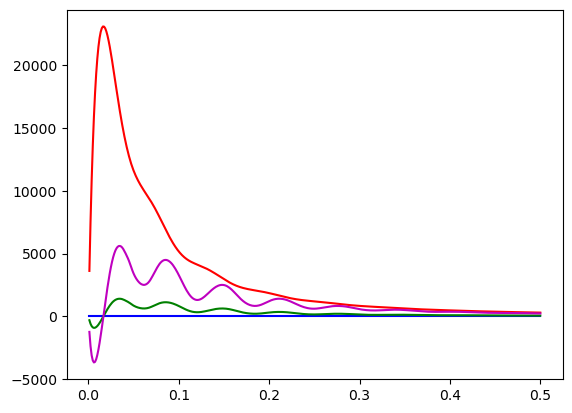

In [38]:
import matplotlib.pyplot as plt
plt.plot(kvec,pkval,color='r')
plt.plot(kvec,derPalphaval[1].T[0],color='b')
plt.plot(kvec,derPalphaval[1].T[30],color='g')
plt.plot(kvec,derPalphaval[1].T[60],color='m')
plt.plot(kvec,kaiser[:,30],color='k')
#plt.plot(kvec,pksmoothval,color='b')
#plt.plot(kvec,derPalpha)

In [1]:
import numpy as np
from findiff import FinDiff
from scipy.integrate import simps
from scipy.interpolate import splrep, splev
from scipy.linalg.lapack import dgesv
from scipy.integrate import quad
from itertools import combinations_with_replacement

muvec = np.linspace(0.0, 1.0, 100)
kvec = np.linspace(cosmo.kmin, cosmo.kmax, 400)
pkval = splev(kvec, cosmo.pk[iz])
pksmoothval = splev(kvec, cosmo.pksmooth[iz])
npop = np.shape(data.nbar)[0]
npk = int(npop * (npop + 1) / 2)

derPalpha = compute_deriv_alphas(cosmo,BAO_only=False)
coords = [[kval, muval] for kval in kvec for muval in muvec]
derPalphaval = [
derPalpha[i](coords).reshape(len(kvec), len(muvec)) * (cosmo.sigma8[iz] / cosmo.sigma8[0]) ** 2
for i in range(2)
]
kaiser = np.tile(data.bias[:, iz], (len(muvec), 1)).T + cosmo.f[iz] * muvec ** 2
bder=np.zeros(len(kvec))
fder=np.zeros(len(kvec))
aperder=np.zeros(len(kvec))
aparder=np.zeros(len(kvec))
#muidx=57
#muval=muvec[muidx]
for j, muval in enumerate(muvec):
    for i, kval in enumerate(kvec):
        derP = compute_full_deriv_uu(
            kval,
            npop,
            npk,
            kaiser[:, j],
            pkval[i],
            pksmoothval[i],
            muval,
            [derPalphaval[0][i, j], derPalphaval[1][i, j]],
            cosmo.f[iz],
            cosmo.sigma8[iz],
            False,
        )
        bder[i]=derP[0][0]
        fder[i]=derP[1][0]
        aperder[i]=derP[2][0]
        aparder[i]=derP[3][0]
        #print(derP[2][0], end=" ")#,derP[3][0])
        #if abs(derP[2][0])>1e5 or abs(derP[3][0])>1e5:
        #    print('ohno',derP[2][0],derP[3][0])
    #plt.plot(kvec,aperder, color='g',label='$\\alpha_\\perp$')
    #plt.plot(kvec,aparder, color='m',label='$\\alpha_\\parallel$')
    #plt.legend()
    #plt.ylabel("$\log\left(\\frac{\partial P_{uu}(k,\mu)}{\partial \\theta_i}\\right)$",fontsize=15,labelpad=-5)
    #plt.xlabel("k (h Mpc$^{-1}$)")
    #plt.title("Derivatives of $P_{{uu}}(k,\mu)$ at $\mu={:.2f}$".format(muval))
    #plt.show()
    #path = '../../Data/Puu/Derivative graphs for Puu at mu={:.2f}.png'.format(muval)
    #plt.savefig(path, dpi=300, bbox_inches='tight')
    #plt.close()

NameError: name 'cosmo' is not defined

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_871/1832664702.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\ln\left(\\frac{\partial P_{uu}(k,\mu)}{\partial \\theta_i}\\right)$",fontsize=15,labelpad=-5)
/tmp/ipykernel_871/1832664702.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Derivatives of $P_{{uu}}(k,\mu)$ at $\mu={:.2f}$".format(muval))


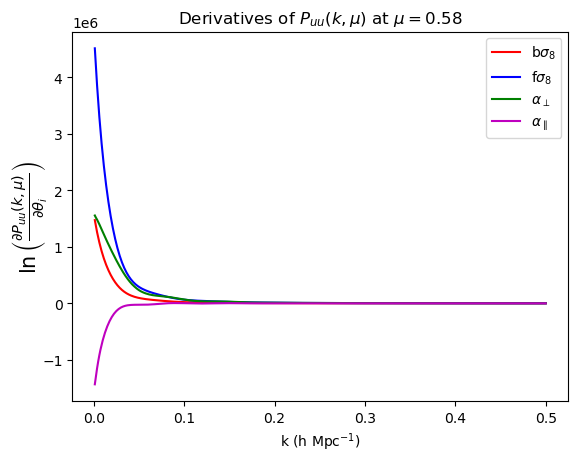

In [4]:
import matplotlib.pyplot as plt
plt.plot(kvec,bder, color='r',label='b$\\sigma_8$')
plt.plot(kvec,fder, color='b',label='f$\\sigma_8$')
plt.plot(kvec,aperder, color='g',label='$\\alpha_\\perp$')
plt.plot(kvec,aparder, color='m',label='$\\alpha_\\parallel$')
plt.legend()
plt.ylabel("$\ln\left(\\frac{\partial P_{uu}(k,\mu)}{\partial \\theta_i}\\right)$",fontsize=15,labelpad=-5)
plt.xlabel("k (h Mpc$^{-1}$)")
plt.title("Derivatives of $P_{{uu}}(k,\mu)$ at $\mu={:.2f}$".format(muval))
plt.show()
#path = '../Figures/Derivative graphs for Pgg at mu={:.2f}.png'.format(muval)
#plt.savefig(path, dpi=300, bbox_inches='tight')
#plt.close()

In [ ]:
print(cosmo.h,cosmo.z) #1/1+z * h = constval

[69.01358329] [0.05]


In [46]:
print(derP)

[[  0.        ]
 [556.7923223 ]
 [266.18002998]
 [198.62991275]]


In [55]:
from PIL import Image, ImageDraw
folder_path = "../../Data/Puu"
output_folder = "../Figures"
output_gif = os.path.join(output_folder, "Derivatives of Puu alphas.gif")
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()
images = [Image.open(img) for img in image_files]
images[0].save(output_gif, save_all=True, append_images=images[1:], duration=100, loop=0)

In [16]:
print(aparder,aperder)

[7.12487724e+11 1.29565519e+11 4.94008416e+10 2.47537465e+10
 1.43272215e+10 9.06875392e+09 6.10084539e+09 4.29028069e+09
 3.12008640e+09 2.32954459e+09 1.77646348e+09 1.37837572e+09
 1.08506873e+09 8.64693599e+08 6.96351283e+08 5.65924391e+08
 4.63632635e+08 3.82552650e+08 3.17687327e+08 2.65368781e+08
 2.22864446e+08 1.88109903e+08 1.59526931e+08 1.35896945e+08
 1.16266099e+08 9.98887314e+07 8.61675474e+07 7.46285120e+07
 6.48895034e+07 5.66390346e+07 4.96282361e+07 4.36529847e+07
 3.85447673e+07 3.41621162e+07 3.03882691e+07 2.71251730e+07
 2.42956590e+07 2.18362305e+07 1.96950779e+07 1.78279425e+07
 1.61916578e+07 1.47507696e+07 1.34762793e+07 1.23442255e+07
 1.13347721e+07 1.04315725e+07 9.62096644e+06 8.89071026e+06
 8.23065738e+06 7.63268400e+06 7.08914214e+06 6.59333064e+06
 6.13996643e+06 5.72445072e+06 5.34226954e+06 4.98955719e+06
 4.66271070e+06 4.35914376e+06 4.07672544e+06 3.81325556e+06
 3.56691514e+06 3.33658141e+06 3.12111738e+06 2.91901997e+06
 2.72967297e+06 2.552373

In [ ]:
muvec = np.linspace(0.0, 1.0, 100)
kvec = np.linspace(cosmo.kmin, cosmo.kmax, 400)
pkval = splev(kvec, cosmo.pk[iz])
pksmoothval = splev(kvec, cosmo.pksmooth[iz])
npop = np.shape(data.nbar)[0]
npk = int(npop * (npop + 1) / 2)

bslay=data.bias[0][0]
#
derPalpha = compute_deriv_alphas_gu(cosmo,bslay,cosmo.f[iz],BAO_only=False)
coords = [[kval, muval] for kval in kvec for muval in muvec]
derPalphaval = [
derPalpha[i](coords).reshape(len(kvec), len(muvec)) * (cosmo.sigma8[iz] / cosmo.sigma8[0]) ** 2
for i in range(2)
]
kaiser = np.tile(data.bias[:, iz], (len(muvec), 1)).T + cosmo.f[iz] * muvec ** 2
bder=np.zeros(len(kvec))
fder=np.zeros(len(kvec))
aperder=np.zeros(len(kvec))
aparder=np.zeros(len(kvec))

for j, muval in enumerate(muvec):
    for i, kval in enumerate(kvec):
        derP = compute_full_deriv_gu(
            kval,
            npop,
            npk,
            kaiser[:, muidx],
            pkval[i],
            pksmoothval[i],
            muval,
            [derPalphaval[0][i, muidx], derPalphaval[1][i, muidx]],
            cosmo.f[iz],
            cosmo.sigma8[iz],
            False,
        )
        bder[i]=derP[0][0]
        fder[i]=derP[1][0]
        aperder[i]=derP[2][0]
        aparder[i]=derP[3][0]
    plt.plot(kvec,bder, color='r',label='b$\\sigma_8$')
    plt.plot(kvec,fder, color='b',label='f$\\sigma_8$')
    plt.plot(kvec,aperder, color='g',label='$\\alpha_\\perp$')
    plt.plot(kvec,aparder, color='m',label='$\\alpha_\\parallel$')
    plt.legend()
    plt.ylabel("$\\frac{\partial P_{gu}(k,\mu)}{\partial \\theta_i}$",fontsize=15,labelpad=-5)
    plt.xlabel("k (h Mpc$^{-1}$)")
    plt.title("Derivatives of $P_{{gu}}(k,\mu)$ at $\mu={:.2f}$".format(muval))
    plt.show()
    #path = '../../Data/Pgu/Derivative graphs for Pgu at mu={:.2f}.png'.format(muval)
    #plt.savefig(path, dpi=300, bbox_inches='tight')
    #plt.close()

<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_6531/1146976559.py:45: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$\\frac{\partial P_{gu}(k,\mu)}{\partial \\theta_i}$",fontsize=15,labelpad=-5)
/tmp/ipykernel_6531/1146976559.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Derivatives of $P_{{gu}}(k,\mu)$ at $\mu={:.2f}$".format(muval))


In [81]:
from PIL import Image, ImageDraw
folder_path = "../../Data/Puu"
output_folder = "../Figures"
output_gif = os.path.join(output_folder, "Derivatives of Puu timelapse.gif")
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()
images = [Image.open(img) for img in image_files]
images[0].save(output_gif, save_all=True, append_images=images[1:], duration=100, loop=0)

In [31]:
import sys
import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, Fish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv

if __name__ == "__main__":

    parent = os.path.abspath("..")
    sys.path.append(parent)

    # Load configuration file
    configpath = os.path.join(parent, "test.ini")
    pardict = ConfigObj(configpath)

    # Read in the file containing the redshift bins, nz and bias values
    data = InputData(pardict)

    # Set up the linear power spectrum and derived parameters based on the input cosmology
    cosmo = CosmoResults(pardict, data.zmin, data.zmax)
    if np.any(data.volume > 0):
        cosmo.volume = data.volume * 1.0e9

    # Convert the nz to nbar in (h/Mpc)^3
    data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

    # Scales the bias so that it goes as b/G(z)
    if pardict.as_bool("scale_bias"):
        data.scale_bias(cosmo.growth)
    print("#  Data nbar")
    print(data.nbar)
    print("#  Data bias")
    print(data.bias)

    # Precompute some things we might need for the Fisher matrix
    recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
    print("#  Data recon factor")
    print(recon)

    # Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
    identity = np.eye(len(data.nbar) + 3)
    print(
        "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
    )
    erralpha = np.zeros(len(cosmo.z))
    FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
    for iz in range(len(cosmo.z)):

        if np.any(data.nz[:, iz] > 1.0e-30):

            Catch = Fish(
                cosmo,
                cosmo.kmin,
                cosmo.kmax,
                data,
                iz,
                recon[iz],
                derPalpha,
                pardict.as_bool("BAO_only"),
                pardict.as_bool("GoFast"),
            )
            # print(Catch)

            # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
            ExtraCatch = Fish(
                cosmo,
                cosmo.kmax,
                0.5,
                data,
                iz,
                recon[iz],
                derPalpha_BAO_only,
                True,
                pardict.as_bool("GoFast"),
            )
            Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

            # Add the Fisher matrix to the full fisher matrix
            FullCatch[
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            ] += Catch[: len(data.nbar), : len(data.nbar)]
            FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
            FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
            FullCatch[-3:, -3:] += Catch[-3:, -3:]

            # Invert the Fisher matrix to get the parameter covariance matrix
            cov = dgesv(Catch, identity)[2]

            # Compute the error on isotropic alpha also
            J = np.array([2.0 / 3.0, 1.0 / 3.0])
            erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

            # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
            means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
            cov_renorm = CovRenorm(cov, means)

            # Print the parameter means and errors
            errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
            print(
                " {0:.2f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
                #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
            )

            # Output the fisher matrix for the redshift bin
            write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

        else:
            erralpha[iz] = 1.0e30
            print(
                " {0:.2f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
            )

    # Run the cosmological parameters at the centre of the combined redshift bin
    identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
    cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

    # Invert the Combined Fisher matrix to get the parameter
    # covariance matrix and compute means and errors
    cov = dgesv(FullCatch, identity)[2]
    J = np.array([2.0 / 3.0, 1.0 / 3.0])
    erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
    means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
    cov_renorm = CovRenorm(cov, means)
    errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
    print("#  Combined errors")
    print("#=================")
    print(
        " {0:.2f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
            cosmo.z[0],
            cosmo.volume[0] / 1e9,
            means[0],
            errs[0],
            means[1],
            errs[1],
            means[2],
            errs[2],
            erralpha,
        )
    )


/root/enidh/code/capstone/Capstone-Project/ioutils.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[4.58078376e-02]
 [3.93200323e-05]]
#  Data bias
[[1.37583381]]
#  Data recon factor
[0.5]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
slay


ValueError: could not broadcast input array from shape (99,) into shape (1,)

In [ ]:
import sys
import os
import numpy as np
from configobj import ConfigObj
from scipy.linalg.lapack import dgesv

# Add parent directory to path
parent = os.path.abspath("..")
sys.path.append(parent)

# Load configuration file
configpath = os.path.join(parent, "test.ini")
pardict = ConfigObj(configpath)

# Import custom modules
from TackleBox import Set_Bait, Fish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher

# Load input data
data = InputData(pardict)

# Set up cosmology
cosmo = CosmoResults(pardict, data.zmin, data.zmax)
if np.any(data.volume > 0):
    cosmo.volume = data.volume * 1.0e9

# Convert nz to nbar
data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

# Optionally scale bias
if pardict.as_bool("scale_bias"):
    data.scale_bias(cosmo.growth)

print("#  Data nbar")
print(data.nbar)
print("#  Data bias")
print(data.bias)

# Precompute derivatives and reconstruction factors
recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
print("#  Data recon factor")
print(recon)

# Initialize Fisher matrix
erralpha = np.zeros(len(cosmo.z))
FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))

print("#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)")

for iz in range(len(cosmo.z)):
    if np.any(data.nz[:, iz] > 1.0e-30):
        kmin_ = float(cosmo.kmin[iz]) if np.ndim(cosmo.kmin) else float(cosmo.kmin)
        kmax_ = float(cosmo.kmax[iz]) if np.ndim(cosmo.kmax) else float(cosmo.kmax)

        Catch = Fish(
            cosmo,
            kmin_,
            kmax_,
            data,
            iz,
            recon[iz],
            derPalpha,
            pardict.as_bool("BAO_only"),
            pardict.as_bool("GoFast"),
        )

        # Add BAO-only info from kmax to 0.5 h/Mpc
        if 0.5 > kmax_:
            ExtraCatch = Fish(
                cosmo,
                kmax_,
                0.5,
                data,
                iz,
                recon[iz],
                derPalpha_BAO_only,
                True,
                pardict.as_bool("GoFast"),
            )
            Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

        # Update FullCatch matrix
        start = iz * len(data.nbar)
        end = (iz + 1) * len(data.nbar)
        FullCatch[start:end, start:end] += Catch[:len(data.nbar), :len(data.nbar)]
        FullCatch[start:end, -3:] += Catch[:len(data.nbar), -3:]
        FullCatch[-3:, start:end] += Catch[-3:, :len(data.nbar)]
        FullCatch[-3:, -3:] += Catch[-3:, -3:]

        # Invert Fisher matrix
        identity = np.eye(Catch.shape[0])
        cov = dgesv(Catch, identity)[2]

        # Compute alpha error
        J = np.array([2.0 / 3.0, 1.0 / 3.0])
        erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

        # Renormalize covariance
        means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
        cov_renorm = CovRenorm(cov, means)
        errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means

        print(
            " {0:.2f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
        )

        write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

    else:
        erralpha[iz] = 1.0e30
        print(
            " {0:.2f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                cosmo.f[iz] * cosmo.sigma8[iz],
                0.0,
                cosmo.da[iz],
                0.0,
                cosmo.h[iz],
                0.0,
                erralpha[iz],
            )
        )

# Final combined Fisher matrix
identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))
cov = dgesv(FullCatch, identity)[2]
J = np.array([2.0 / 3.0, 1.0 / 3.0])
erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
cov_renorm = CovRenorm(cov, means)
errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means

print("#  Combined errors")
print("#=================")
print(
    " {0:.2f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
        cosmo.z[0],
        cosmo.volume[0] / 1e9,
        means[0],
        errs[0],
        means[1],
        errs[1],
        means[2],
        errs[2],
        erralpha,
    )
)


/root/enidh/code/capstone/Capstone-Project/ioutils.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[0.04580784]
 [0.00458078]]
#  Data bias
[[1.37583381]]
#  Data recon factor
[0.5]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
slay


ValueError: could not broadcast input array from shape (99,) into shape (1,)